In [3]:
import os
import json
import time
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
from typing import List

import umap
import umap.plot

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
from sklearn.model_selection import train_test_split

device = "cpu"

# Load Dataset

In [4]:
DOMAIN = "fashion"

current_dir = os.path.abspath(os.curdir)
base_dir = "/".join(current_dir.split("/")[:-1])
dataset_dir = Path(base_dir).joinpath(f"data/dataset/{DOMAIN}/interactions")
model_dir = Path(base_dir).joinpath(f"data/model/{DOMAIN}/transformer")
model_dir.mkdir(parents=True, exist_ok=True)

In [5]:
df = pd.read_parquet(dataset_dir)
df.head()
df["date"] = pd.to_datetime(df["timestamp"].apply(lambda x: x[:10]), format="%Y-%m-%d")

# User Behavior Sequence

In [6]:
df_agg = df.groupby(["date", "user_id"])["item_id"].agg(n_items="nunique").reset_index()
df_agg = df_agg.groupby("date")["n_items"].mean().reset_index()
df_agg = df_agg[df_agg["date"] < "2025-10-01"].reset_index(drop=True)

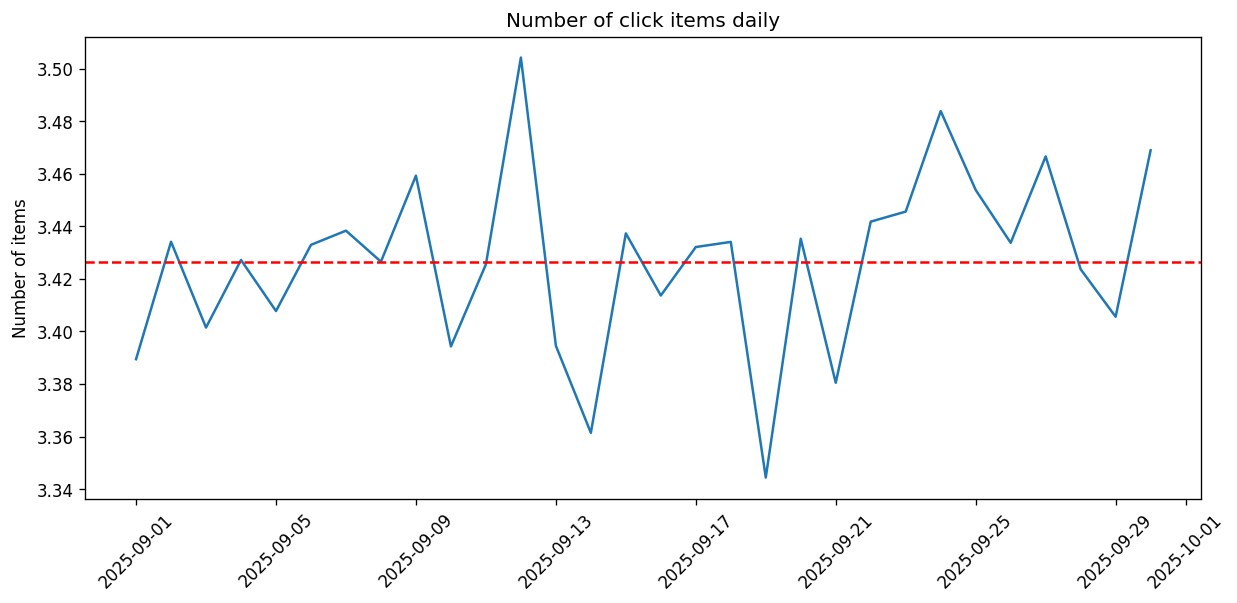

In [7]:
plt.figure(figsize=(12, 5), dpi=120)
sns.lineplot(data=df_agg, x="date", y="n_items")
plt.xlabel("")
plt.ylabel("Number of items")
plt.xticks(rotation=45)
plt.axhline(y=df_agg["n_items"].mean(), color="r", linestyle="--")
plt.title("Number of click items daily")
plt.show()

In [8]:
max_seq_len = 4

# Preprocess

In [9]:
from utils.preprocess import FeatureLabelEncoder, SequenceGenerator, SequentialDataset

## Label Encoding

In [10]:
feature_names = ["color", "style", "fit", "material", "season", "sleeve", "category"]

label_encoders = FeatureLabelEncoder()
df_tmp = pd.concat(
    [
        pd.DataFrame([dict(zip(feature_names, ["NONE"] * len(feature_names)))]),
        pd.DataFrame([dict(zip(feature_names, ["-1"] * len(feature_names)))]),
    ]
)
df_prep = pd.concat([df[feature_names], df_tmp])
label_encoders.fit(df_prep)
df_encoded = label_encoders.transform(df_prep)

for column in ["item_id", "user_id", "timestamp"]:
    values = df[column].to_list()
    random_values = values[: df_tmp.shape[0]]
    df_encoded[column] = values + random_values
print(df_encoded.shape)
df_encoded[["user_id", "item_id", "timestamp"] + feature_names].head()

# Mask로 처리할 인덱스가 모두 0으로 인코딩 되었는지 확인
for x in feature_names:
    x_encoded = label_encoders._all_encoders[x].transform(["-1"])
    x_decoded = label_encoders._all_encoders[x].inverse_transform([0])
    print(f"{x}: {x_encoded} -> {x_decoded}")

(161348, 10)
color: [0] -> ['-1']
style: [0] -> ['-1']
fit: [0] -> ['-1']
material: [0] -> ['-1']
season: [0] -> ['-1']
sleeve: [0] -> ['-1']
category: [0] -> ['-1']


In [11]:
model_dir.joinpath(f"label_encoders/").mkdir(parents=True, exist_ok=True)

for feature, encoder in label_encoders.all_encoders.items():
    file_name = f"{feature}.joblib"
    file_path = model_dir.joinpath(f"label_encoders/{file_name}")
    joblib.dump(encoder, file_path)

## Sequence Generation

In [12]:
target_names = feature_names

sequence_generator = SequenceGenerator(max_seq_len=max_seq_len)
df_seq_encoded = sequence_generator.get_seq_dataframe(
    data=df_encoded,
    feature_sequences=feature_names,
    output_targets=target_names,
)

# `item_id` 타겟 추가
df_seq_encoded["y_item_id"] = df_seq_encoded.groupby("user_id")["item_id"].shift(-1)

# Null target 제거
df_seq_encoded = df_seq_encoded[df_seq_encoded.notna().all(axis=1)].reset_index(
    drop=True
)

print(df_seq_encoded.shape)

(141814, 20)


In [13]:
df_seq_encoded.head()

,user_id,item_id,user_rn,seq_len,mask,color,style,fit,material,season,sleeve,category,y_color,y_style,y_fit,y_material,y_season,y_sleeve,y_category,y_item_id
0,1,6099,1,4,"[0, 0, 0, 0]","[17, 17, 6, 6]","[7, 7, 9, 9]","[3, 2, 4, 6]","[9, 3, 7, 6]","[2, 6, 5, 6]","[1, 5, 7, 7]","[17, 17, 8, 8]",17,2,6,12,2,5,17,8096.0
1,1,8096,2,4,"[0, 0, 0, 0]","[6, 17, 17, 17]","[9, 2, 2, 2]","[6, 6, 6, 7]","[6, 12, 14, 10]","[6, 2, 6, 6]","[7, 5, 7, 1]","[8, 17, 17, 17]",16,2,2,14,6,7,3,4411.0
2,1,4411,3,4,"[0, 0, 0, 0]","[17, 6, 6, 17]","[7, 9, 9, 2]","[2, 4, 6, 6]","[3, 7, 6, 12]","[6, 5, 6, 2]","[5, 7, 7, 5]","[17, 8, 8, 17]",17,2,6,14,6,7,17,3730.0
3,1,3730,4,4,"[0, 0, 0, 0]","[6, 6, 17, 17]","[9, 9, 2, 2]","[4, 6, 6, 6]","[7, 6, 12, 14]","[5, 6, 2, 6]","[7, 7, 5, 7]","[8, 8, 17, 17]",17,2,7,10,6,1,17,1679.0
4,1,1679,5,4,"[0, 0, 0, 0]","[17, 16, 16, 11]","[2, 2, 2, 9]","[7, 2, 2, 4]","[10, 14, 10, 11]","[6, 6, 3, 6]","[1, 7, 1, 1]","[17, 3, 3, 3]",1,1,1,1,1,2,1,5383.0


# Model

## Model Config

In [14]:
def set_model_config(
    df: pd.DataFrame, feature_names: List[str], target_names: List[str], seq_len: int
) -> dict:
    feature_dims = {}
    for feature in feature_names:
        feature_dims[feature] = np.max(df[feature].to_list()).item() + 1

    embedding_dim = 64
    output_dims = {}
    for target in target_names:
        output_dims[target] = df[target].nunique()

    return dict(
        seq_len=seq_len,
        feature_dims=feature_dims,
        embedding_dim=embedding_dim,
        output_dims=output_dims,
        global_pool="sum",
    )


print("------------------ Model Config ------------------")
model_config = set_model_config(
    df=df_encoded,
    feature_names=feature_names,
    target_names=feature_names,
    seq_len=max_seq_len,
)
print(model_config)

checkpoint = model_dir.joinpath("checkpoint")
checkpoint.mkdir(parents=True, exist_ok=True)

with open(checkpoint.joinpath("model_config.json"), "w") as f:
    json.dump(model_config, f, ensure_ascii=False, indent=4)

------------------ Model Config ------------------
{'seq_len': 4, 'feature_dims': {'color': 18, 'style': 13, 'fit': 8, 'material': 16, 'season': 7, 'sleeve': 8, 'category': 23}, 'embedding_dim': 64, 'output_dims': {'color': 18, 'style': 13, 'fit': 8, 'material': 16, 'season': 7, 'sleeve': 8, 'category': 23}, 'global_pool': 'sum'}


## Dataset

In [15]:
df_train, df_test = train_test_split(
    df_seq_encoded, test_size=0.2, random_state=42, shuffle=True
)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [16]:
train_dataset = SequentialDataset(
    df=df_train, feature_sequences=feature_names + ["mask"], targets=target_names
)

batch_size = 128
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=False
)

## Training

In [17]:
from utils.transformer import SimpleTransformerRec

In [17]:
torch.autograd.set_detect_anomaly(True)

# Model
model = SimpleTransformerRec(**model_config)

# Loss functions
loss_funcs = {
    target: nn.CrossEntropyLoss(ignore_index=0).to(device) for target in target_names
}

# Optimizers
optimizer = optim.AdamW(model.parameters(), weight_decay=0.01, lr=0.001)

df_metrics = pd.DataFrame()
n_epochs = 10
model = model.to(device)
for epoch in range(n_epochs):
    train_start_time = time.time()
    model.train()

    running_loss = {target: 0 for target in target_names}
    accuracy = {}
    for target in target_names:
        accuracy.update({target: {"token": [], "sequence": []}})

    for _, (feature_sequences, masks, targets) in enumerate(
        tqdm(train_dataloader, total=len(train_dataloader))
    ):
        optimizer.zero_grad()
        outputs = model(feature_sequences=feature_sequences, masks=masks)[1]
        losses = {target: 0 for target in target_names}
        for target, dim in model_config["output_dims"].items():
            batch_size = targets[target].size()[0]

            # logits_flat: (seq_len * batch_size, n_classes)
            logits_flat = outputs[target].permute(1, 0, 2).reshape(-1, dim)

            # targets_flat: (batch_size * seq_len)
            targets_flat = targets[target].reshape(-1).long()

            losses[target] = loss_funcs[target](logits_flat, targets_flat)

            # pred_flat: (batch_size * seq_len)
            pred_flat = logits_flat.argmax(dim=-1)

            # Token-Level Accuracy (예측 시퀀스와 Target 시퀀스 내 동일한 원소 비율)
            correct = (pred_flat == targets_flat) & (targets_flat != 0)
            valid_token_cnt = (targets_flat != 0).sum().item()
            # division by zero 에러 방지
            if valid_token_cnt > 0:
                token_accuracy = correct.sum().item() / valid_token_cnt
            else:
                token_accuracy = 0.0

            # Sequence-Level Accuracy (예측 시퀀스와 Target 시퀀스가 동일한 비율)
            # pred: (seq_len, batch_size)
            pred = pred_flat.reshape(batch_size, model.seq_len)
            sequence_correct = ((pred == targets[target]) & (masks.long() == 0)).all(
                dim=1
            )
            sequence_accuracy = sequence_correct.sum().item() / batch_size

            accuracy[target]["token"].append(token_accuracy)
            accuracy[target]["sequence"].append(sequence_accuracy)

        total_loss = sum(losses.values())
        total_loss.backward()
        optimizer.step()

        for target, loss in losses.items():
            running_loss[target] += loss.item()
        running_loss["total"] = total_loss.item()

    torch.save(model.state_dict(), checkpoint.joinpath("model.pt"))

    train_end_time = time.time()
    train_time = round(train_end_time - train_start_time, 2)
    print(f"Epoch {epoch + 1}/{n_epochs} - Loss & Accuracy (Token, Sequence)")
    for target in target_names:
        loss = running_loss[target] / len(train_dataloader)
        token_accuracy = np.mean(accuracy[target]["token"])
        sequence_accuracy = np.mean(accuracy[target]["sequence"])
        print(
            f"Loss `{target}`: {loss:.4f} ({token_accuracy:.2%}, {sequence_accuracy:.2%})"
        )

        df_metrics_tmp = pd.DataFrame(
            {
                "epoch": [epoch + 1],
                "target": [target],
                "loss": [loss],
                "token_accuracy": [token_accuracy],
                "sequence_accuracy": [sequence_accuracy],
            }
        )
        df_metrics = pd.concat([df_metrics, df_metrics_tmp], ignore_index=True)
    print(f"Total Loss: {running_loss['total']:.4f}")
    print(f"Elapsed time(sec): {train_time:.2f}\n")

df_metrics.to_csv(model_dir.joinpath("metrics_train.csv"), index=False)

/Users/hwangyungwan/miniforge3/envs/ds_p313/lib/python3.13/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


  0%|          | 0/887 [00:00<?, ?it/s]

Epoch 1/10 - Loss & Accuracy (Token, Sequence)
Loss `color`: 0.2839 (96.05%, 74.02%)
Loss `style`: 0.2062 (97.77%, 76.28%)
Loss `fit`: 0.1355 (98.73%, 77.56%)
Loss `material`: 0.2383 (96.98%, 75.09%)
Loss `season`: 0.1147 (99.13%, 78.39%)
Loss `sleeve`: 0.1322 (98.82%, 77.79%)
Loss `category`: 0.3272 (95.45%, 73.29%)
Total Loss: 0.0656
Elapsed time(sec): 85.13



  0%|          | 0/887 [00:00<?, ?it/s]

Epoch 2/10 - Loss & Accuracy (Token, Sequence)
Loss `color`: 0.0067 (100.00%, 80.19%)
Loss `style`: 0.0052 (100.00%, 80.19%)
Loss `fit`: 0.0036 (100.00%, 80.19%)
Loss `material`: 0.0058 (100.00%, 80.19%)
Loss `season`: 0.0033 (100.00%, 80.19%)
Loss `sleeve`: 0.0036 (100.00%, 80.19%)
Loss `category`: 0.0076 (100.00%, 80.19%)
Total Loss: 0.0170
Elapsed time(sec): 87.18



  0%|          | 0/887 [00:00<?, ?it/s]

Epoch 3/10 - Loss & Accuracy (Token, Sequence)
Loss `color`: 0.0022 (100.00%, 80.20%)
Loss `style`: 0.0017 (100.00%, 80.20%)
Loss `fit`: 0.0012 (100.00%, 80.20%)
Loss `material`: 0.0019 (100.00%, 80.20%)
Loss `season`: 0.0011 (100.00%, 80.20%)
Loss `sleeve`: 0.0012 (100.00%, 80.20%)
Loss `category`: 0.0025 (100.00%, 80.20%)
Total Loss: 0.0075
Elapsed time(sec): 87.29



  0%|          | 0/887 [00:00<?, ?it/s]

Epoch 4/10 - Loss & Accuracy (Token, Sequence)
Loss `color`: 0.0010 (100.00%, 80.20%)
Loss `style`: 0.0008 (100.00%, 80.20%)
Loss `fit`: 0.0006 (100.00%, 80.20%)
Loss `material`: 0.0009 (100.00%, 80.20%)
Loss `season`: 0.0005 (100.00%, 80.20%)
Loss `sleeve`: 0.0006 (100.00%, 80.20%)
Loss `category`: 0.0012 (100.00%, 80.20%)
Total Loss: 0.0048
Elapsed time(sec): 85.25



  0%|          | 0/887 [00:00<?, ?it/s]

Epoch 5/10 - Loss & Accuracy (Token, Sequence)
Loss `color`: 0.0006 (100.00%, 80.20%)
Loss `style`: 0.0004 (100.00%, 80.20%)
Loss `fit`: 0.0003 (100.00%, 80.20%)
Loss `material`: 0.0005 (100.00%, 80.20%)
Loss `season`: 0.0003 (100.00%, 80.20%)
Loss `sleeve`: 0.0003 (100.00%, 80.20%)
Loss `category`: 0.0006 (100.00%, 80.20%)
Total Loss: 0.0023
Elapsed time(sec): 90.68



  0%|          | 0/887 [00:00<?, ?it/s]

Epoch 6/10 - Loss & Accuracy (Token, Sequence)
Loss `color`: 0.0003 (100.00%, 80.21%)
Loss `style`: 0.0002 (100.00%, 80.21%)
Loss `fit`: 0.0002 (100.00%, 80.21%)
Loss `material`: 0.0003 (100.00%, 80.21%)
Loss `season`: 0.0002 (100.00%, 80.21%)
Loss `sleeve`: 0.0002 (100.00%, 80.21%)
Loss `category`: 0.0004 (100.00%, 80.21%)
Total Loss: 0.0014
Elapsed time(sec): 85.82



  0%|          | 0/887 [00:00<?, ?it/s]

Epoch 7/10 - Loss & Accuracy (Token, Sequence)
Loss `color`: 0.0002 (100.00%, 80.19%)
Loss `style`: 0.0001 (100.00%, 80.19%)
Loss `fit`: 0.0001 (100.00%, 80.19%)
Loss `material`: 0.0002 (100.00%, 80.19%)
Loss `season`: 0.0001 (100.00%, 80.19%)
Loss `sleeve`: 0.0001 (100.00%, 80.19%)
Loss `category`: 0.0002 (100.00%, 80.19%)
Total Loss: 0.0007
Elapsed time(sec): 84.98



  0%|          | 0/887 [00:00<?, ?it/s]

Epoch 8/10 - Loss & Accuracy (Token, Sequence)
Loss `color`: 0.0014 (99.98%, 80.14%)
Loss `style`: 0.0105 (99.88%, 79.98%)
Loss `fit`: 0.0007 (99.99%, 80.18%)
Loss `material`: 0.0014 (99.98%, 80.13%)
Loss `season`: 0.0005 (99.99%, 80.18%)
Loss `sleeve`: 0.0007 (99.99%, 80.18%)
Loss `category`: 0.0020 (99.96%, 80.10%)
Total Loss: 0.0020
Elapsed time(sec): 90.49



  0%|          | 0/887 [00:00<?, ?it/s]

Epoch 9/10 - Loss & Accuracy (Token, Sequence)
Loss `color`: 0.0002 (100.00%, 80.21%)
Loss `style`: 0.0002 (100.00%, 80.20%)
Loss `fit`: 0.0001 (100.00%, 80.20%)
Loss `material`: 0.0002 (100.00%, 80.21%)
Loss `season`: 0.0001 (100.00%, 80.21%)
Loss `sleeve`: 0.0001 (100.00%, 80.21%)
Loss `category`: 0.0002 (100.00%, 80.20%)
Total Loss: 0.0006
Elapsed time(sec): 94.62



  0%|          | 0/887 [00:00<?, ?it/s]

Epoch 10/10 - Loss & Accuracy (Token, Sequence)
Loss `color`: 0.0001 (100.00%, 80.20%)
Loss `style`: 0.0001 (100.00%, 80.20%)
Loss `fit`: 0.0001 (100.00%, 80.20%)
Loss `material`: 0.0001 (100.00%, 80.20%)
Loss `season`: 0.0000 (100.00%, 80.20%)
Loss `sleeve`: 0.0001 (100.00%, 80.20%)
Loss `category`: 0.0001 (100.00%, 80.20%)
Total Loss: 0.0007
Elapsed time(sec): 103.09



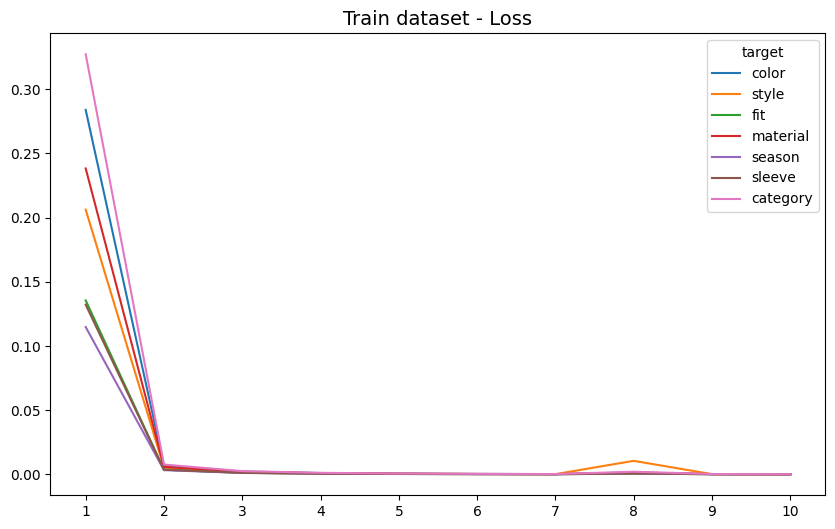

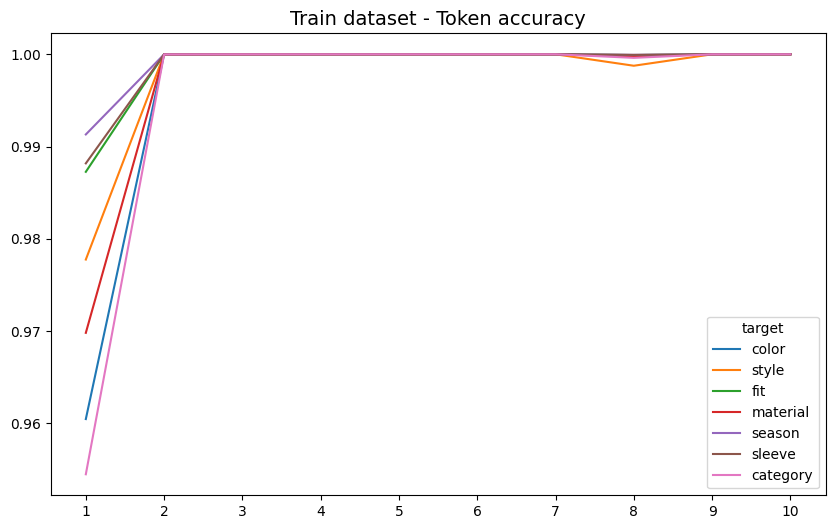

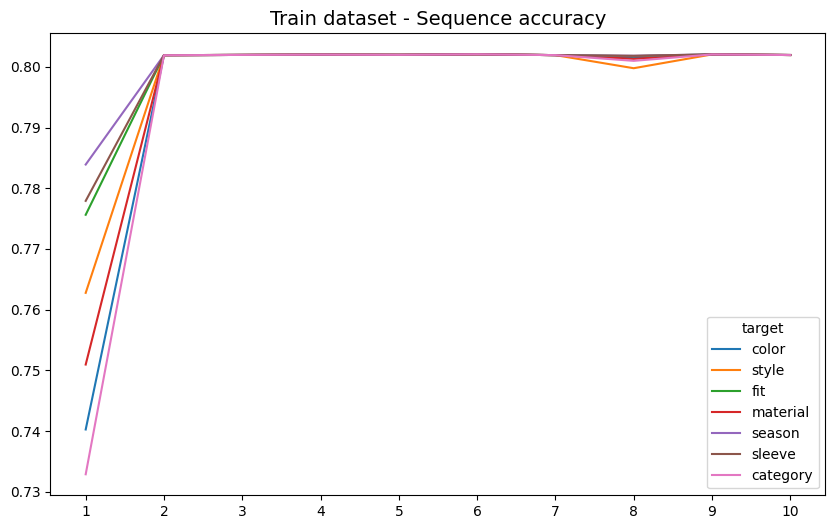

In [18]:
df_metrics = pd.read_csv(model_dir.joinpath("metrics_train.csv"))

for metric in ["loss", "token_accuracy", "sequence_accuracy"]:
    plt.figure(figsize=(10, 6), dpi=100)
    sns.lineplot(x="epoch", y=metric, hue="target", data=df_metrics)
    plt.title(f"Train dataset - {metric.replace('_', ' ').capitalize()}", fontsize=14)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(np.arange(1, df_metrics["epoch"].max() + 1, 1))
    plt.show()

## Evaluation

In [19]:
test_dataset = SequentialDataset(
    df=df_test, feature_sequences=feature_names + ["mask"], targets=target_names
)

batch_size = 128
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval().to(device)
with torch.no_grad():
    accuracy = {}
    for target in target_names:
        accuracy.update({target: {"token": [], "sequence": []}})

    for _, (feature_sequences, masks, targets) in enumerate(
        tqdm(test_dataloader, total=len(test_dataloader))
    ):
        outputs = model(feature_sequences=feature_sequences, masks=masks)[1]

        for target, dim in model_config["output_dims"].items():
            batch_size = targets[target].size()[0]

            # logits_flat: (batch_size * seq_len, n_classes)
            logits_flat = outputs[target].permute(1, 0, 2).reshape(-1, dim)

            # targets_flat: (batch_size * seq_len)
            targets_flat = targets[target].reshape(-1).long()

            # pred_flat: (batch_size * seq_len)
            pred_flat = logits_flat.argmax(dim=-1)

            # Token-Level Accuracy (예측 시퀀스와 Target 시퀀스 내 동일한 원소 비율)
            correct = (pred_flat == targets_flat) & (targets_flat != 0)
            valid_token_cnt = (targets_flat != 0).sum().item()
            # division by zero 에러 방지
            if valid_token_cnt > 0:
                token_accuracy = correct.sum().item() / valid_token_cnt
            else:
                token_accuracy = 0.0

            # Sequence-Level Accuracy (예측 시퀀스와 Target 시퀀스가 동일한 비율)
            # pred: (seq_len, batch_size)
            pred = pred_flat.reshape(batch_size, model.seq_len)
            sequence_correct = ((pred == targets[target]) & (masks.long() == 0)).all(
                dim=1
            )
            sequence_accuracy = sequence_correct.sum().item() / batch_size

            accuracy[target]["token"].append(token_accuracy)
            accuracy[target]["sequence"].append(sequence_accuracy)

    df_metrics = pd.DataFrame()
    print("Accuracy (Token, Sequence)")
    for i, target in enumerate(target_names):
        token_accuracy = np.mean(accuracy[target]["token"])
        sequence_accuracy = np.mean(accuracy[target]["sequence"])
        print(f"`{target}`: {token_accuracy:.2%}, {sequence_accuracy:.2%}")

        df_metrics_tmp = pd.DataFrame(
            {
                "target": [target],
                "token_accuracy": [token_accuracy],
                "sequence_accuracy": [sequence_accuracy],
            }
        )
        df_metrics = pd.concat([df_metrics, df_metrics_tmp], ignore_index=True)

df_metrics.to_csv(model_dir.joinpath("metrics_test.csv"), index=False)

  0%|          | 0/222 [00:00<?, ?it/s]

Accuracy (Token, Sequence)
`color`: 100.00%, 80.44%
`style`: 100.00%, 80.44%
`fit`: 100.00%, 80.44%
`material`: 100.00%, 80.44%
`season`: 100.00%, 80.44%
`sleeve`: 100.00%, 80.44%
`category`: 100.00%, 80.44%


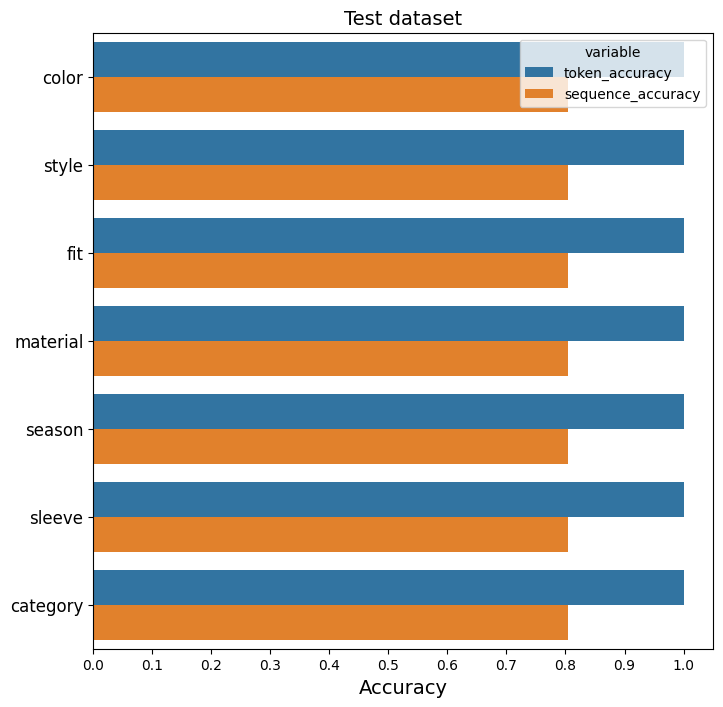

In [20]:
df_metrics = pd.read_csv(model_dir.joinpath("metrics_test.csv"))
df_metrics = df_metrics.melt(id_vars="target")
plt.figure(figsize=(8, 8), dpi=100)
sns.barplot(data=df_metrics, x="value", y="target", hue="variable")
plt.title("Test dataset", fontsize=14)
plt.xlabel("Accuracy", fontsize=14)
plt.ylabel("", fontsize=14)
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(fontsize=12)
plt.show()

# Sequence Vectors

In [19]:
f = open(model_dir.joinpath("checkpoint/model_config.json"))
model_config = json.load(f)

model = SimpleTransformerRec(**model_config)
model.load_state_dict(
    torch.load(
        f=model_dir.joinpath("checkpoint/model.pt"),
        map_location=torch.device(device),
        weights_only=True,
    )
)
model = model.to(device)

/Users/hwangyungwan/miniforge3/envs/ds_p313/lib/python3.13/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [20]:
df_tmp = df_seq_encoded[feature_names + ["mask", "y_item_id"]]

dataset = SequentialDataset(
    df=df_tmp, feature_sequences=feature_names + ["mask"], device=device
)

dataloader = DataLoader(dataset, batch_size=512, shuffle=False, pin_memory=False)

seq_vectors = []
with torch.no_grad():
    for _, (feature_sequences, masks) in enumerate(
        tqdm(dataloader, total=len(dataloader))
    ):
        outputs = model(feature_sequences=feature_sequences, masks=masks)[0]

        outputs = outputs.detach().numpy()
        seq_vectors.extend([value / np.linalg.norm(value) for value in outputs])

df_seq_vectors = df_seq_encoded[feature_names + ["y_item_id"]].copy()
df_seq_vectors["vector"] = seq_vectors
seq_vectors = np.array(df_seq_vectors["vector"].tolist())

  0%|          | 0/277 [00:00<?, ?it/s]

In [21]:
seq_vectors.shape

(141814, 64)

/var/folders/9r/nl1h4s_n0wx65wzr5cmq1hy80000gn/T/ipykernel_23563/3069121192.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


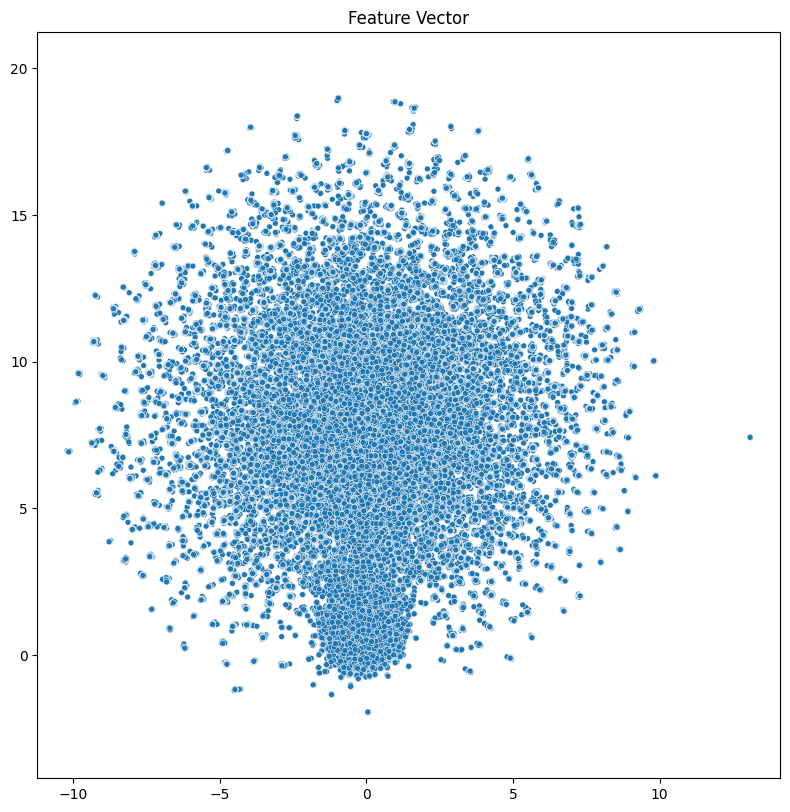

In [22]:
reducer = umap.UMAP(metric="cosine", n_neighbors=15)
embeddings = reducer.fit_transform(seq_vectors)

plt.figure(figsize=(8, 8))
sns.scatterplot(
    x=embeddings[:, 0], y=embeddings[:, 1], size=0.3, palette="bright", legend=False
)
plt.gca().set_aspect("equal", "datalim")
plt.tight_layout()
plt.title("Feature Vector")
plt.show()

# Projection Model
- Sequence Vector -> Item Vector

In [23]:
model_dir = Path(base_dir).joinpath(f"data/model/{DOMAIN}/regressor")
model_dir.mkdir(parents=True, exist_ok=True)

checkpoint = model_dir.joinpath("checkpoint")
checkpoint.mkdir(parents=True, exist_ok=True)

## Sequence Vector Extraction

In [24]:
seq_vectors = []

model.eval().to(device)
with torch.no_grad():
    for feature_sequences, masks in tqdm(dataloader, total=len(dataloader)):
        outputs = model(feature_sequences=feature_sequences, masks=masks)[0]

        outputs = outputs.detach().cpu().numpy()
        seq_vectors.extend(
            [(value / np.linalg.norm(value)).tolist() for value in outputs]
        )

df_seq_vectors = df_seq_encoded.loc[:, ["y_item_id"]]
df_seq_vectors["y_item_id"] = df_seq_vectors["y_item_id"].astype(int)
df_seq_vectors["vector"] = seq_vectors

  0%|          | 0/277 [00:00<?, ?it/s]

## Dataset

In [25]:
item_metadata_path = Path(base_dir).joinpath(
    f"data/dataset/{DOMAIN}/item_metadata.parquet"
)
df_item = pd.read_parquet(item_metadata_path)

text_vector_path = Path(base_dir).joinpath(
    f"data/dataset/{DOMAIN}/text_vectors.parquet"
)
df_text_vectors = pd.read_parquet(text_vector_path)

In [26]:
item_vectors_map = dict(
    zip(df_text_vectors["item_id"], df_text_vectors["text_vector"].to_numpy())
)

seq_vector_dim = model_config["embedding_dim"]
item_vector_dim = max([len(v) for k, v in item_vectors_map.items()])

In [27]:
from utils.preprocess import SequenceVectorDataset

In [28]:
train_dataset = SequenceVectorDataset(
    device=device,
    item_id=df_seq_encoded["y_item_id"].to_numpy().astype(np.int32),
    seq_vector=np.array(df_seq_vectors["vector"].to_list(), dtype=np.float32),
)
train_dataloader = DataLoader(
    train_dataset, batch_size=1024, shuffle=True, pin_memory=False
)

## Training

In [30]:
from utils.regressor import MultiOutputRegressor

In [31]:
reg_model = MultiOutputRegressor(
    input_dim=seq_vector_dim, output_dim=item_vector_dim, dropout=0.0
)
reg_model.to(device)

with open(checkpoint.joinpath("model_config.json"), "w") as f:
    json.dump(reg_model.config, f, ensure_ascii=False, indent=4)

criterion = nn.MSELoss()
optimizer = optim.AdamW(reg_model.parameters(), lr=0.001)

df_metrics = pd.DataFrame()
n_epochs = 30

for epoch in range(n_epochs):
    reg_model.train()
    losses = []

    train_start_time = time.time()

    target_item_ids = df_seq_vectors["y_item_id"].unique().tolist()

    for item_ids, seq_vectors in tqdm(train_dataloader, total=len(train_dataloader)):
        # BatchNorm 통과 시 `batch_size`가 1일 때 2개로 복제
        if item_ids.size(0) == 1:
            item_ids = item_ids.repeat(2, 1)
            seq_vectors = seq_vectors.repeat(2, 1)

        optimizer.zero_grad()
        outputs = reg_model(seq_vectors)

        # `item_id` to `vector`
        item_vector = np.array(
            [
                item_vectors_map.get(item_id.item(), np.array([0] * item_vector_dim))
                for item_id in item_ids
            ]
        ).astype(np.float32)
        item_vector = torch.from_numpy(item_vector).to(device)

        loss = torch.sqrt(criterion(outputs, item_vector))
        losses.append(loss.detach().cpu().numpy())
        loss.backward()
        optimizer.step()

    torch.save(reg_model.state_dict(), checkpoint.joinpath("model.pt"))

    train_end_time = time.time()
    train_time = round(train_end_time - train_start_time, 2)
    print(f"Epoch {epoch + 1}/{n_epochs} - Elapsed time(sec): {train_time:.2f}")
    print(f"Loss MSE: {np.mean(losses):.5f}")

    df_metrics = pd.concat(
        [df_metrics, pd.DataFrame({"epoch": [epoch + 1], "mse": [np.mean(losses)]})],
        ignore_index=True,
    )

df_metrics.to_csv(model_dir.joinpath("metrics_train.csv"), index=False)

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1/30 - Elapsed time(sec): 6.84
Loss MSE: 0.03785


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2/30 - Elapsed time(sec): 5.49
Loss MSE: 0.01232


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 3/30 - Elapsed time(sec): 5.96
Loss MSE: 0.01214


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 4/30 - Elapsed time(sec): 5.32
Loss MSE: 0.01192


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 5/30 - Elapsed time(sec): 5.25
Loss MSE: 0.01171


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 6/30 - Elapsed time(sec): 6.33
Loss MSE: 0.01156


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 7/30 - Elapsed time(sec): 5.39
Loss MSE: 0.01134


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 8/30 - Elapsed time(sec): 6.04
Loss MSE: 0.01126


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 9/30 - Elapsed time(sec): 6.70
Loss MSE: 0.01109


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 10/30 - Elapsed time(sec): 5.86
Loss MSE: 0.01107


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 11/30 - Elapsed time(sec): 7.88
Loss MSE: 0.01099


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 12/30 - Elapsed time(sec): 6.59
Loss MSE: 0.01093


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 13/30 - Elapsed time(sec): 5.51
Loss MSE: 0.01093


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 14/30 - Elapsed time(sec): 5.66
Loss MSE: 0.01090


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 15/30 - Elapsed time(sec): 5.47
Loss MSE: 0.01086


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 16/30 - Elapsed time(sec): 5.26
Loss MSE: 0.01083


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 17/30 - Elapsed time(sec): 5.31
Loss MSE: 0.01083


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 18/30 - Elapsed time(sec): 5.81
Loss MSE: 0.01081


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 19/30 - Elapsed time(sec): 5.11
Loss MSE: 0.01080


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 20/30 - Elapsed time(sec): 6.28
Loss MSE: 0.01078


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 21/30 - Elapsed time(sec): 5.10
Loss MSE: 0.01077


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 22/30 - Elapsed time(sec): 5.31
Loss MSE: 0.01077


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 23/30 - Elapsed time(sec): 6.08
Loss MSE: 0.01077


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 24/30 - Elapsed time(sec): 6.04
Loss MSE: 0.01076


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 25/30 - Elapsed time(sec): 5.69
Loss MSE: 0.01075


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 26/30 - Elapsed time(sec): 5.00
Loss MSE: 0.01075


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 27/30 - Elapsed time(sec): 5.13
Loss MSE: 0.01075


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 28/30 - Elapsed time(sec): 5.03
Loss MSE: 0.01074


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 29/30 - Elapsed time(sec): 5.11
Loss MSE: 0.01073


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 30/30 - Elapsed time(sec): 5.06
Loss MSE: 0.01071


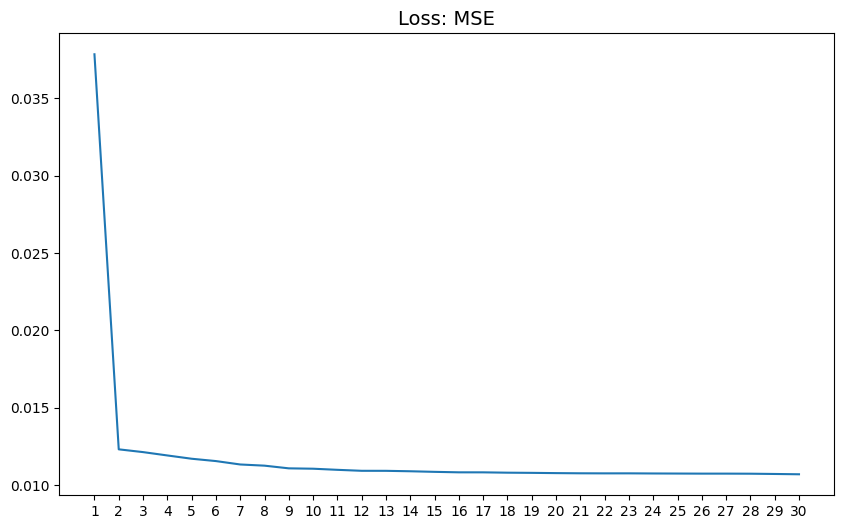

In [37]:
df_metrics = pd.read_csv(model_dir.joinpath("metrics_train.csv"))

plt.figure(figsize=(10, 6), dpi=100)
sns.lineplot(x="epoch", y="mse", data=df_metrics)
plt.title("Loss: MSE", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks(np.arange(1, df_metrics["epoch"].max() + 1, 1))
plt.show()